In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm

from keras.models import Sequential 
from keras.layers import Dense  ,Dropout
from keras.optimizers import Adam

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor ,ExtraTreesRegressor ,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.svm import SVR

from scipy.stats import zscore

# Prepare

In [3]:
def _load_data():
    train=pd.read_excel('Data set - Tisa.xlsx',sheet_name='Training set 2011-2015')
    train.columns=['temperature', 'solids', 'dissolved_oxygen', 'pH','electrical', 'NH4', 'NO2', 'NO3', 'TN', 'PO4P', 'BOD5']
    train=train.drop(list(train[train.isna().any(axis=1)].index),axis=0)

    test=pd.read_excel('Data set - Tisa.xlsx',sheet_name='Testing set 2016-2019 ')
    test.columns=['temperature', 'solids', 'dissolved_oxygen', 'pH','electrical', 'NH4', 'NO2', 'NO3', 'TN', 'PO4P', 'BOD5']
    test=test.drop(list(test[test.isna().any(axis=1)].index),axis=0)

    print(train.shape,test.shape)
    return train , test

def _prepare_data(data):
    X_train=data.drop(['dissolved_oxygen'],axis=1)
    y_train=data.dissolved_oxygen
    return X_train , y_train


def _calc_corr(y_test,y_pred,sqrt=False):
    res=pd.DataFrame(y_pred,columns=['pred'])
    res['real']=y_test
    if sqrt:
        return np.sqrt(res.corr())
    else: return res.corr()

def _zscore(df):
    df_scaled=zscore(df,axis=1)
    return df_scaled

def _scale_data(X_train,y_train,X_test,y_test,same=False):
    X_scaler=StandardScaler()
    X_train_scaled=X_scaler.fit_transform(X_train)
    y_scaler=StandardScaler()
    y_train_scaled=y_scaler.fit_transform(np.array(y_train).reshape(-1,1))    
    if same:
        X_test_scaled=X_scaler.transform(X_test)
        y_test_scaled=y_scaler.transform(np.array(y_test).reshape(-1,1))

        return X_train_scaled,y_train_scaled,X_test_scaled,y_test_scaled
    else:
        X_test_scaler=StandardScaler()
        y_test_scaler=StandardScaler()
        X_test_scaled=X_test_scaler.fit_transform(X_test)
        y_test_scaled=y_test_scaler.fit_transform(np.array(y_test).reshape(-1,1))  
        return X_train_scaled,y_train_scaled,X_test_scaled,y_test_scaled    

#create a function to find outliers using IQR
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

def _relative_error(y_test,y_pred):
    re=[]
    for item in range(len(y_test)):
        re.append((abs(y_test[item]-y_pred[item])/y_test[item])*100)
    return np.mean(re)

def _errors(y_test, y_pred):
    mse=mean_squared_error(y_test, y_pred)
    rmse=np.sqrt(mse)
    relative=_relative_error(y_test,y_pred)
    mae=mean_absolute_error(y_test, y_pred)
    corr=_calc_corr(y_test,y_pred,sqrt=False)
    sq_corr=r2_score(y_test,y_pred)
    print(f"mse: {mse}\nrmse: {rmse}\nrelative: {relative} %\nmae: {mae}\ncorr:{corr['real']['pred']}\nsq_corr:{sq_corr}\n")
    return [mse,rmse,relative,mae,corr['real']['pred'],sq_corr]

def _drop_outliers(train,test,drop_test=False):
    train=train[find_outliers_IQR(train).isna()].dropna()
    if drop_test:
        test=test[find_outliers_IQR(test).isna()].dropna()
        print(train.shape,test.shape)
        return train,test
    else:
        print(train.shape,test.shape)
        return train,test

def _augment_data(df,n=1000):
    #creating fake data
    fake=pd.DataFrame([list(range(1,len(df.columns)+1))],columns=df.columns,index=range(n))
    fake.columns
    for item in fake.columns:
        fake[item]=np.random.random(n)
    fake['fake']=np.ones(len(fake))
    # concatenate fake and real data
    df['fake']=np.zeros(len(df))
    temp=pd.concat([fake,df],axis=0)
    temp.reset_index(drop=True,inplace=True)
    # Augment data
    X=temp.drop(['fake'],axis=1)
    y=temp.fake
    # transform the dataset
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    X['fake']=y
    temp=X[X.fake==0]
    temp.drop(['fake'],axis=1,inplace=True)
    temp.reset_index(drop=True,inplace=True)
    return temp

def _dataset_type(train, test, type='ds1'):
    if type=='ds1':
        train.drop(['solids','NO2', 'NO3', 'TN','BOD5'],axis=1,inplace=True)
        test.drop(['solids','NO2', 'NO3', 'TN','BOD5'],axis=1,inplace=True)
        return train , test
    elif type=='ds2':
        train.drop(['solids','NO2', 'NO3', 'TN','BOD5','NH4'],axis=1,inplace=True)
        test.drop(['solids','NO2', 'NO3', 'TN','BOD5','NH4'],axis=1,inplace=True)
        return train , test
    elif type=='ds3':
        train.drop(['solids','NO2', 'NO3', 'TN','BOD5','NH4','electrical'],axis=1,inplace=True)
        test.drop(['solids','NO2', 'NO3', 'TN','BOD5','NH4','electrical'],axis=1,inplace=True) 
        return train , test  

# data

In [4]:
# load
train,test=_load_data()

# dataset type
train , test = _dataset_type(train, test,type='ds1')

# drop outliers
train,test=_drop_outliers(train , test,drop_test=True)

# z score standard 
train=_zscore(train)
test =_zscore(test)

# Augment data

# train=_augment_data(train,n=1000)
print(train.shape)

# train test and x y split
X_train , y_train=_prepare_data(train)
X_test , y_test =_prepare_data(test)



(605, 11) (461, 11)
(466, 6) (339, 6)
(466, 6)


# Models

## Machine Learning

In [55]:
# model checkpoint
# - ExtraTreeRegressor
# - this model has r2=0.741
# joblib.dump(model, 'extratreereg.joblib.pkl', compress=9)
model= joblib.load('extratreereg.joblib.pkl')

In [87]:
model=KNeighborsRegressor()
model.fit(X_train.values,y_train)
y_pred=model.predict(X_test.values)
_errors(y_test.values, y_pred)

mse: 0.3589497508925861
rmse: 0.5991241531540737
relative: 6846.61064982145 %
mae: 0.42801483805367946
corr:0.802122713418148
sq_corr:0.6410502491074139



[0.3589497508925861,
 0.5991241531540737,
 6846.61064982145,
 0.42801483805367946,
 0.802122713418148,
 0.6410502491074139]

In [88]:
model=DecisionTreeRegressor()
model.fit(X_train.values,y_train)
y_pred=model.predict(X_test)
_errors(y_test.values, y_pred)

mse: 0.557946984543674
rmse: 0.7469584891703648
relative: 3774.6978308569 %
mae: 0.5345342197800231
corr:0.7196925936858217
sq_corr:0.442053015456326



/home/zaniargh42/.local/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


[0.557946984543674,
 0.7469584891703648,
 3774.6978308569,
 0.5345342197800231,
 0.7196925936858217,
 0.442053015456326]

In [89]:
model=RandomForestRegressor()
model.fit(X_train.values,y_train)
y_pred=model.predict(X_test)
_errors(y_test.values, y_pred)

mse: 0.32244888126934396
rmse: 0.5678458252636396
relative: 5827.3243782786085 %
mae: 0.38867983259842404
corr:0.8242536102962836
sq_corr:0.677551118730656



/home/zaniargh42/.local/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


[0.32244888126934396,
 0.5678458252636396,
 5827.3243782786085,
 0.38867983259842404,
 0.8242536102962836,
 0.677551118730656]

In [90]:
model=GradientBoostingRegressor()
model.fit(X_train.values,y_train)
y_pred=model.predict(X_test)
_errors(y_test.values, y_pred)

mse: 0.3079007120670025
rmse: 0.5548880175918403
relative: 5360.5035112858695 %
mae: 0.3775573511961226
corr:0.8355811106024965
sq_corr:0.6920992879329975



/home/zaniargh42/.local/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


[0.3079007120670025,
 0.5548880175918403,
 5360.5035112858695,
 0.3775573511961226,
 0.8355811106024965,
 0.6920992879329975]

In [91]:
model=SVR()
model.fit(X_train.values,y_train)
y_pred=model.predict(X_test)
_errors(y_test.values, y_pred)

mse: 0.3069057019868111
rmse: 0.5539907056863058
relative: 4891.9485710719 %
mae: 0.3713532004630767
corr:0.8337166424738669
sq_corr:0.6930942980131889



/home/zaniargh42/.local/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


[0.3069057019868111,
 0.5539907056863058,
 4891.9485710719,
 0.3713532004630767,
 0.8337166424738669,
 0.6930942980131889]

In [92]:
model=MLPRegressor()
model.fit(X_train.values,y_train)
y_pred=model.predict(X_test)
_errors(y_test.values, y_pred)

mse: 0.2866537827814137
rmse: 0.5354005816035444
relative: 5649.215208292452 %
mae: 0.36125869926666976
corr:0.8458438823268267
sq_corr:0.7133462172185863



/home/zaniargh42/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zaniargh42/.local/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


[0.2866537827814137,
 0.5354005816035444,
 5649.215208292452,
 0.36125869926666976,
 0.8458438823268267,
 0.7133462172185863]

## DL Model

Epoch 1/150
16/16 [==============================] - 1s 19ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 2/150
16/16 [==============================] - 0s 7ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 3/150
16/16 [==============================] - 0s 6ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 4/150
16/16 [==============================] - 0s 7ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 5/150
16/16 [==============================] - 0s 9ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 6/150
16/16 [==============================] - 0s 7ms/step - loss: 1.0000 - val_loss: 0.9999
Epoch 7/150
16/16 [==============================] - 0s 7ms/step - loss: 0.9999 - val_loss: 0.9999
Epoch 8/150
16/16 [==============================] - 0s 7ms/step - loss: 0.9999 - val_loss: 0.9999
Epoch 9/150
16/16 [==============================] - 0s 7ms/step - loss: 0.9998 - val_loss: 0.9998
Epoch 10/150
16/16 [==============================] - 0s 8ms/step - loss: 0.9998 - val_loss: 0.9997
Epoch 11

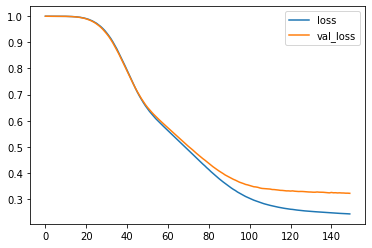

mse: 0.32202964762018377
rmse: 0.5674765612958687
relative: 5749.03857421875 %
mae: 0.3831345308906208
corr:0.824351058346981
sq_corr:0.6779703523798162



[0.32202964762018377,
 0.5674765612958687,
 5749.0386,
 0.3831345308906208,
 0.824351058346981,
 0.6779703523798162]

In [94]:
def _compile_model(X_train,y_train,X_test,y_test,epochs,batch_size):
    model = Sequential()
    model.add(Dense(15, input_shape=(X_train[0].shape[0],),kernel_initializer='RandomNormal', activation='relu'))
    model.add(Dense(17,kernel_initializer='RandomNormal', activation='relu'))
    model.add(Dense(10,kernel_initializer='RandomNormal', activation='relu'))
    model.add(Dense(7,kernel_initializer='RandomNormal', activation='relu'))
    model.add(Dense(1,kernel_initializer='RandomNormal',activation='linear'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer=Adam(0.0001))
    model.fit(X_train, y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test))
    
    history=model.history
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    return history , r2 , y_pred,model
history , r2 , y_pred,model=_compile_model(X_train.values,y_train.values,X_test.values,y_test.values,150,30)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
_errors(y_test.values,y_pred)

## Hybrid model

In [90]:
model = Sequential()
model.add(Dense(15, input_shape=(X_train[0].shape[0],),kernel_initializer='RandomNormal', activation='relu'))
model.add(Dense(17,kernel_initializer='RandomNormal', activation='relu'))
model.add(Dense(20,kernel_initializer='RandomNormal', activation='relu'))
model.add(Dense(30,kernel_initializer='RandomNormal', activation='relu'))
model.add(Dense(40,kernel_initializer='RandomNormal',activation='linear'))

# Compile model
model.compile(loss='mean_squared_error', optimizer=Adam(0.0001))
model.fit(X_train, y_train,epochs=100,batch_size=30,validation_data=(X_test,y_test))


Epoch 1/100
167/167 [==============================] - 1s 4ms/step - loss: 0.9994 - val_loss: 0.9971
Epoch 2/100
167/167 [==============================] - 0s 3ms/step - loss: 0.9653 - val_loss: 0.9093
Epoch 3/100
167/167 [==============================] - 0s 3ms/step - loss: 0.7286 - val_loss: 0.5804
Epoch 4/100
167/167 [==============================] - 0s 3ms/step - loss: 0.3854 - val_loss: 0.4047
Epoch 5/100
167/167 [==============================] - 0s 3ms/step - loss: 0.2792 - val_loss: 0.3753
Epoch 6/100
167/167 [==============================] - 0s 3ms/step - loss: 0.2482 - val_loss: 0.3644
Epoch 7/100
167/167 [==============================] - 0s 3ms/step - loss: 0.2288 - val_loss: 0.3589
Epoch 8/100
167/167 [==============================] - 0s 3ms/step - loss: 0.2151 - val_loss: 0.3550
Epoch 9/100
167/167 [==============================] - 0s 3ms/step - loss: 0.2049 - val_loss: 0.3540
Epoch 10/100
167/167 [==============================] - 0s 3ms/step - loss: 0.1964 - val_lo

In [91]:
nnf_train=model.predict(X_train)
nnf_test=model.predict(X_test)
nnf_train.shape

9/9 [==============================] - 0s 2ms/step


(5000, 40)

# Inverse values

In [158]:
train,test=_load_data()
# dataset type
train , test = _dataset_type(train, test,type='ds3')
# drop outliers
train,test=_drop_outliers(train , test,drop_test=True)

mean=[]
std=[]
for item in test.index:
    mean.append(np.mean(list(test.loc[item,:])))
    std.append(np.std(list(test.loc[item,:])))

(605, 11) (461, 11)
(510, 4) (383, 4)


In [159]:
test['mean']=mean
test['std']=std
test.to_excel('ds1_mean.xlsx')